# Instructions to run
First, install the libraries in the cell below, if not already installed.
Then run all cells.

In [1]:
#!pip install numpy pandas scikit-learn matplotlib seaborn kagglehub statsmodels scipy

In [2]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Kaggle API
import kagglehub

# Statsmodels for statistical analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import Log

from statsmodels.gam.api import GLMGam, BSplines # Could not get pygam to work; switched to this
from statsmodels.genmod.families import Binomial

# Statistical testing
from scipy.stats import shapiro

# ChatGPT used to facilitate import cleanliness

In [3]:
# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn") 
# from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code

print("Path to dataset files:", path)

Path to dataset files: /Users/ryan/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [4]:
# Extract data from csv to Pandas dataframe
csv_file_path = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(csv_file_path, index_col='customerID')
print(df.head())

            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
7590-VHVEG  Female              0     Yes         No       1           No   
5575-GNVDE    Male              0      No         No      34          Yes   
3668-QPYBK    Male              0      No         No       2          Yes   
7795-CFOCW    Male              0      No         No      45           No   
9237-HQITU  Female              0      No         No       2          Yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  No phone service             DSL             No          Yes   
5575-GNVDE                No             DSL            Yes           No   
3668-QPYBK                No             DSL            Yes          Yes   
7795-CFOCW  No phone service             DSL            Yes           No   
9237

In [5]:
# Data cleanup

# Convert TotalCharges to numeric, coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values in the TotalCharges column
df = df.dropna(subset=['TotalCharges'])

# Verify that missing values have been dropped
print(df['TotalCharges'].isnull().sum())  # Should print 0
print(f"Rows remaining: {df.shape[0]}")

#ChatGPT used to identify possible interferences and cleanup data

0
Rows remaining: 7032


In [6]:
# Target variable converted to continuous variable
df['Churn'] = df['Churn'].map({'Yes': 1.0, 'No': 0.0})
print(df.head())

#ChatGPT used for syntax

            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
7590-VHVEG  Female              0     Yes         No       1           No   
5575-GNVDE    Male              0      No         No      34          Yes   
3668-QPYBK    Male              0      No         No       2          Yes   
7795-CFOCW    Male              0      No         No      45           No   
9237-HQITU  Female              0      No         No       2          Yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  No phone service             DSL             No          Yes   
5575-GNVDE                No             DSL            Yes           No   
3668-QPYBK                No             DSL            Yes          Yes   
7795-CFOCW  No phone service             DSL            Yes           No   
9237

In [7]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=[
    'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
], drop_first=True)

# Check the processed DataFrame
print(df_encoded.info())
print(df_encoded.head())

#ChatGPT used to avoid errors

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   MonthlyCharges                         7032 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   Churn                                  7032 non-null   float64
 5   gender_Male                            7032 non-null   bool   
 6   Partner_Yes                            7032 non-null   bool   
 7   Dependents_Yes                         7032 non-null   bool   
 8   PhoneService_Yes                       7032 non-null   bool   
 9   MultipleLines_No phone service         7032 non-null   bool   
 10  MultipleLines_Yes                      7032 non-null   bool   

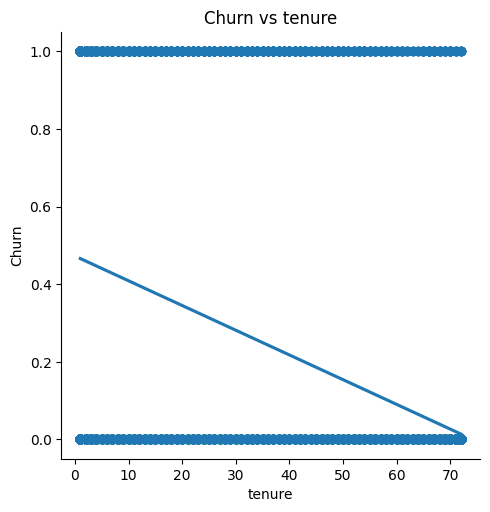

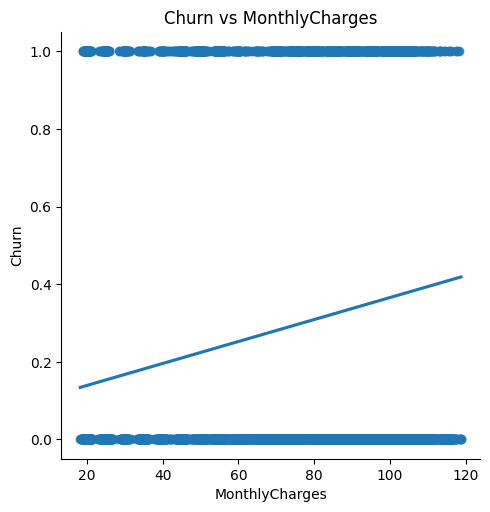

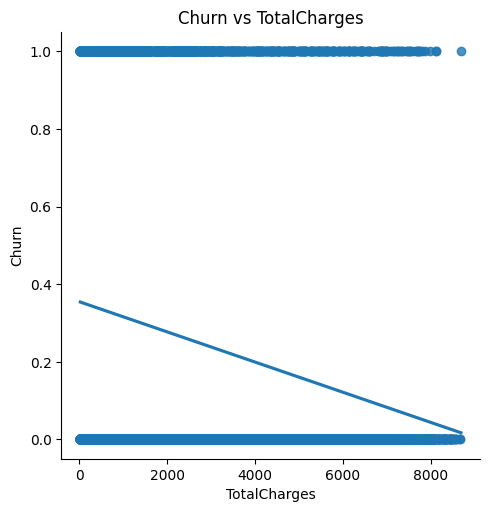

In [8]:
# Churn vs continuous predictors scatterplot

# List of continuous predictors
continuous_predictors = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plot scatterplots with regression lines
for predictor in continuous_predictors:
    sns.lmplot(x=predictor, y='Churn', data=df_encoded, logistic=False, ci=None)
    plt.title(f'Churn vs {predictor}')
    plt.show()

# Scatterplot Analysis

There appears to be a linear relationship between the continuous predictors and the target. The categorical data is not appropriate for this kind of analysis. This validates the linearity assumption for those predictors.

In [9]:
# Test for no multicollinearity with Variance Inflation Factor (VIF)

# Drop non-numeric and target columns (Churn) to calculate VIF
X = df_encoded.drop(columns=['Churn', 'customerID'], errors='ignore')
X = X.astype({col: 'int' for col in X.select_dtypes(include=['bool']).columns})

# Add a constant for intercept
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_data)


                                  Feature         VIF
0                                   const    0.000000
1                           SeniorCitizen    1.153220
2                                  tenure    7.584453
3                          MonthlyCharges  866.089640
4                            TotalCharges   10.811490
5                             gender_Male    1.002106
6                             Partner_Yes    1.462988
7                          Dependents_Yes    1.381598
8                        PhoneService_Yes         inf
9          MultipleLines_No phone service         inf
10                      MultipleLines_Yes    7.289761
11            InternetService_Fiber optic  148.500814
12                     InternetService_No         inf
13     OnlineSecurity_No internet service         inf
14                     OnlineSecurity_Yes    6.338349
15       OnlineBackup_No internet service         inf
16                       OnlineBackup_Yes    6.796678
17   DeviceProtection_No int

/Users/ryan/Projects/XAI/XAIenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/ryan/Projects/XAI/XAIenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


# Multicollinearity Analysis

Given that I one-hot encoded some of the categorical variables, some of those encodings are completely aligned with their counterparts.

Monthly Charges is extremely correlated with other features, probably with Total Charges and likely others as the more you pay the more services you likely have.

Some other features like Payment Method are not highly correlated with other features, which makes sense as they are simple preferences.

Overall, the high VIF scores of some important variables indicates a high degree of multicollinearity which is not good.

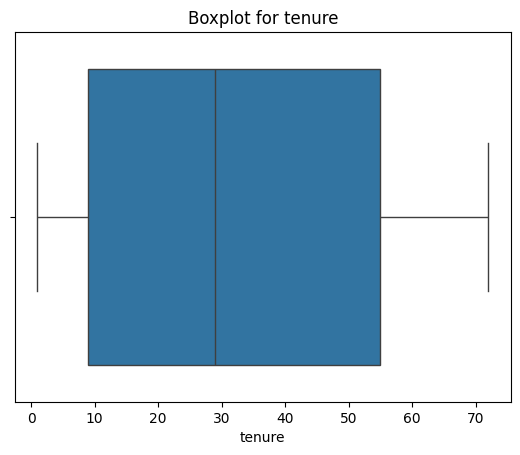

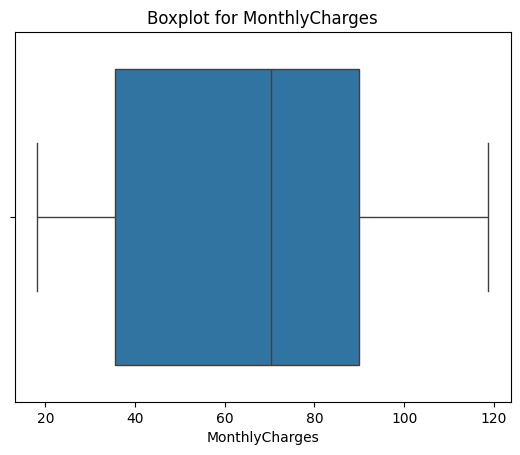

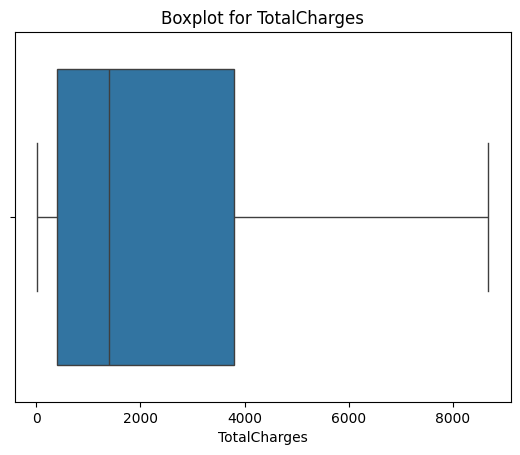

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     120.9
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        02:04:21   Log-Likelihood:                -3057.9
No. Observations:                7032   AIC:                             6164.
Df Residuals:                    7008   BIC:                             6328.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [10]:
# Test for major outliers

# Create boxplots for each continuous predictor
for predictor in continuous_predictors:
    sns.boxplot(x=df_encoded[predictor])
    plt.title(f"Boxplot for {predictor}")
    plt.show()


# Create the Linear Regression model

# Define predictors (X) and target (y)
y = df_encoded['Churn']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())


In [11]:
# Extract residuals and fitted values
residuals = model.resid
fitted = model.fittedvalues


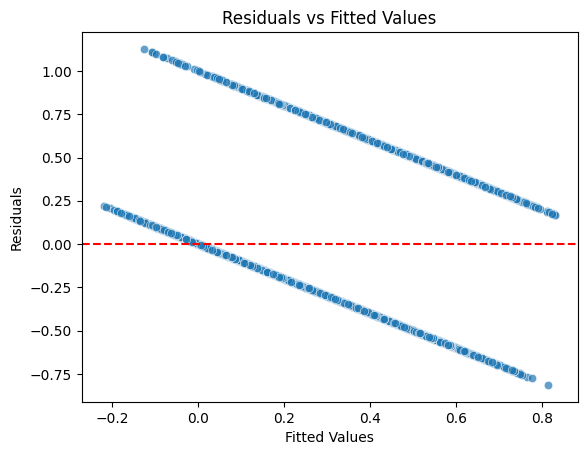

In [12]:
# Test of Homoscedasticity
# Residuals vs Fitted Values
sns.scatterplot(x=fitted, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()


# Test of Homoscedasticity

The shape of the plot shows that the variance is not constant across all levels of the fitted values, and ideally they should be randomly scattered around the red line. This indicates heteroscedasticity which violates the assumption for Linear Regression.

In [13]:
# Test Normality of Residuals

stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}")


Shapiro-Wilk Test: Statistic=0.9620382866355996, p-value=2.0788787028188256e-39


/Users/ryan/Projects/XAI/XAIenv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7032.
  res = hypotest_fun_out(*samples, **kwds)


# Test Normality of Residuals

The p-value is practically 0, far below the 0.05 threshold, so the data definitely does not follow a normal distribution, violating that assumption.

In [14]:
# Test Homoscedasticity

bp_test = het_breuschpagan(residuals, X)
print(f"Breusch-Pagan Test: LM Statistic={bp_test[0]}, p-value={bp_test[1]}")


Breusch-Pagan Test: LM Statistic=1370.4798293512508, p-value=1.4942610721168889e-269


# Another test of Homoscedasticity

Similarly, the p-value is close to 0, so the data is heteroscedastic.

In [15]:
# Test Independence of Residuals

# Perform Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")


Durbin-Watson Statistic: 2.004347318931738


# Test Independence of Residuals

A value close to 2 indicates no autocorrelation. It is very close to 2, which is a good sign for the assumption of independence of errors.

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Snippet slightly modified from: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/interpretable-ml-example-notebooks/regression-interpretability.ipynb


Linear Regression:
MSE: 0.15
R2 Score: 0.25
const: 0.0000
SeniorCitizen: 0.0201
tenure: -0.0463
MonthlyCharges: -0.1109
TotalCharges: -0.1030
gender_Male: -0.0018
Partner_Yes: 0.0035
Dependents_Yes: -0.0130
PhoneService_Yes: 0.0063
MultipleLines_No phone service: -0.0063
MultipleLines_Yes: 0.0338
InternetService_Fiber optic: 0.1358
InternetService_No: -0.0138
OnlineSecurity_No internet service: -0.0138
OnlineSecurity_Yes: -0.0168
OnlineBackup_No internet service: -0.0138
OnlineBackup_Yes: 0.0036
DeviceProtection_No internet service: -0.0138
DeviceProtection_Yes: 0.0102
TechSupport_No internet service: -0.0138
TechSupport_Yes: -0.0172
StreamingTV_No internet service: -0.0138
StreamingTV_Yes: 0.0449
StreamingMovies_No internet service: -0.0138
StreamingMovies_Yes: 0.0465
Contract_One year: -0.0477
Contract_Two year: -0.0318
PaperlessBilling_Yes: 0.0177
PaymentMethod_Credit card (automatic): -0.0039
PaymentMethod_Electronic check: 0.0295
PaymentMethod_Mailed check: -0.0027


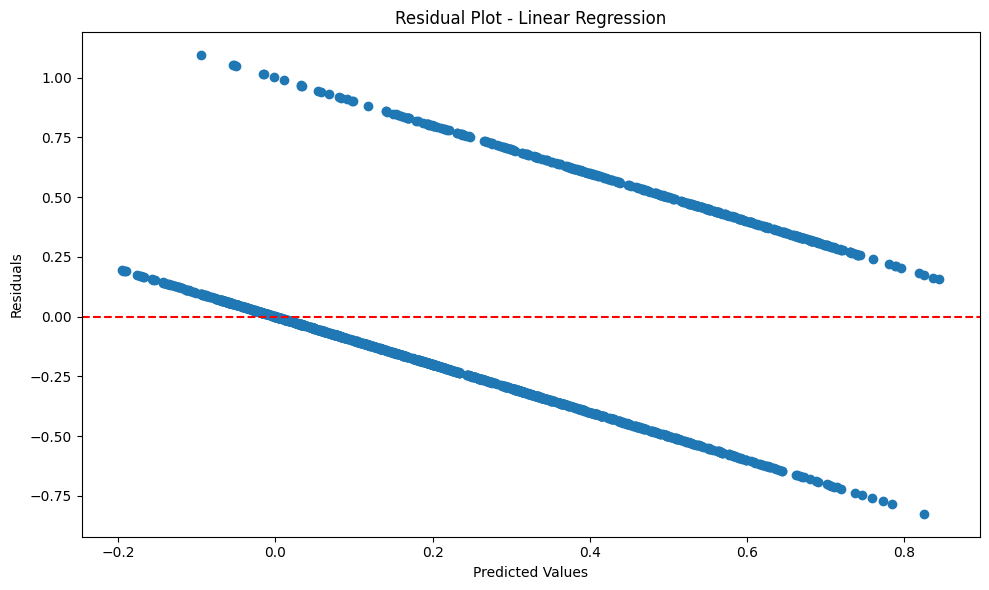

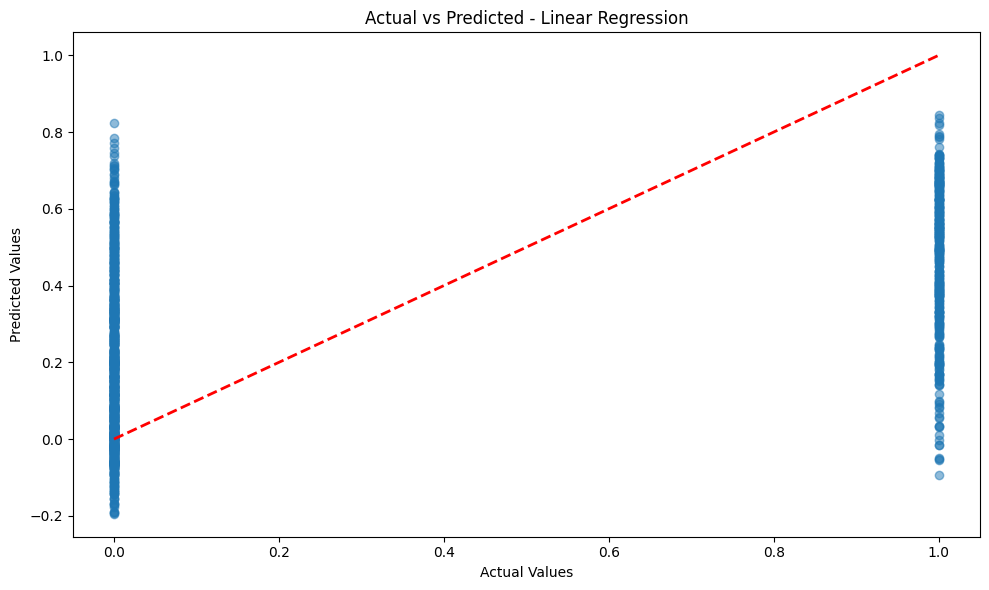

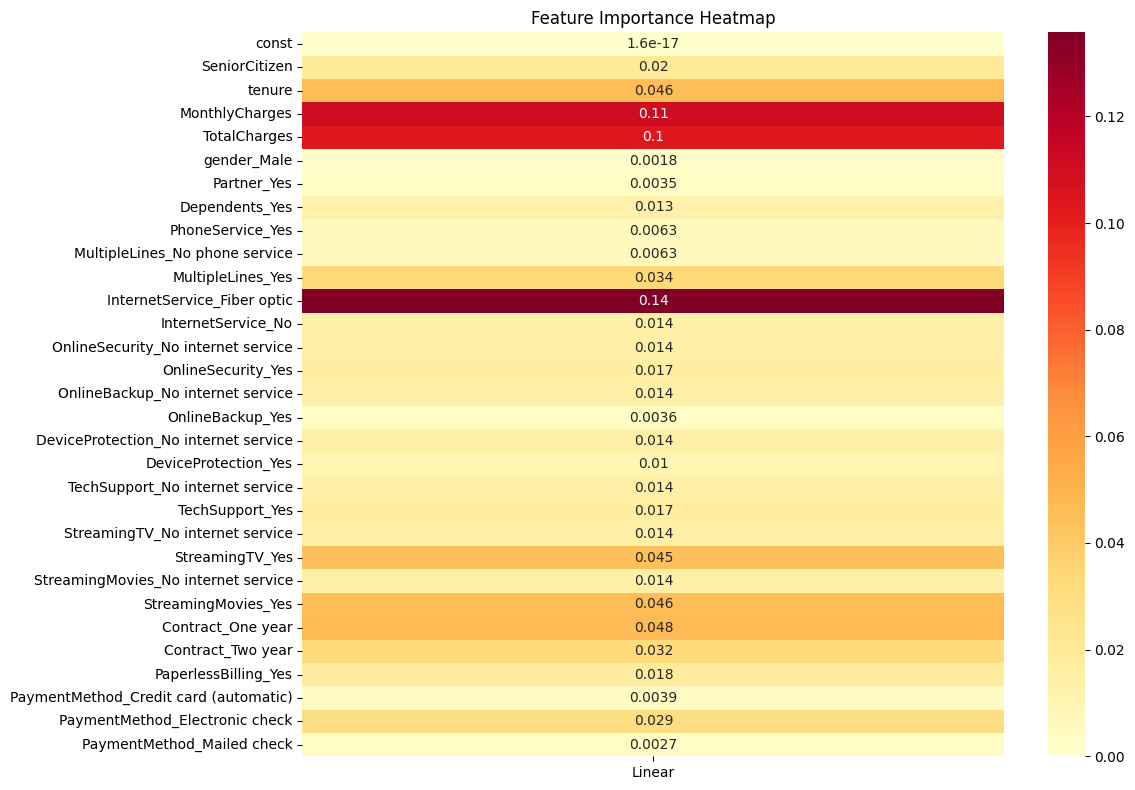

In [17]:
# Evaluation and results of Linear Regression

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred

lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")

# Residual Plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, lr_pred, 'Linear Regression')

# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, lr_pred, 'Linear Regression')

# Feature Importance Heatmap
def plot_feature_importance_heatmap(lr_model):
    importance_df = pd.DataFrame({
        'Linear': np.abs(lr_model.coef_),
    }, index=X.columns)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(lr_model)

# Snippet modified from: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/interpretable-ml-example-notebooks/regression-interpretability.ipynb

In [18]:
# Predict values using the linear regression model
y_pred = model.predict(X)  # model.predict() returns continuous values

# Define a threshold (e.g., 0.5 for classification)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert continuous values to binary (0 or 1)

# Calculate accuracy (number of correct predictions / total predictions)
accuracy = accuracy_score(y, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")

# ChatGPT used for speed

Accuracy: 0.8023


# Analysis of Linear Regression Model

Evidently, using linear regression on a binary target and a lot of categorical data is not ideal, with unusual looking plots and middling MSE and R2 scores. However, the accuracy is actually reasonable. It is good to see that Monthly Charges and Total Charges have large coefficients and are negative, which intuitively makes sense as those who pay more might be less likely to churn. Fiber Optic has a high score which also makes sense as those who invest in the infrastructure are less likely to churn. Those results are essentially the same as those in the feature importance heatmap.

In [19]:
# Preparation for Logistic Regression

# Scale the features and retain column names
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

def evaluate_logr_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1
    y_pred = model.predict(X_test)  # Predicted classes
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC-ROC: {auc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print feature coefficients
    print("\nFeature Coefficients:")
    for feature, coef in zip(X_train.columns, model.coef_.flatten()):
        print(f"{feature}: {coef:.4f}")

    return model, y_pred, y

# ChatGPT used to write this


Logistic Regression:
Accuracy: 0.79
AUC-ROC: 0.83

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1033
         1.0       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Feature Coefficients:
const: 0.0000
SeniorCitizen: 0.0950
tenure: -1.4457
MonthlyCharges: -0.6328
TotalCharges: 0.6949
gender_Male: -0.0158
Partner_Yes: 0.0251
Dependents_Yes: -0.0998
PhoneService_Yes: -0.0297
MultipleLines_No phone service: 0.0297
MultipleLines_Yes: 0.1605
InternetService_Fiber optic: 0.6507
InternetService_No: -0.0741
OnlineSecurity_No internet service: -0.0741
OnlineSecurity_Yes: -0.1555
OnlineBackup_No internet service: -0.0741
OnlineBackup_Yes: -0.0091
DeviceProtection_No internet service: -0.0741
DeviceProtection_Yes: 0.0401
TechSupport_No internet service: -0.0741
Te

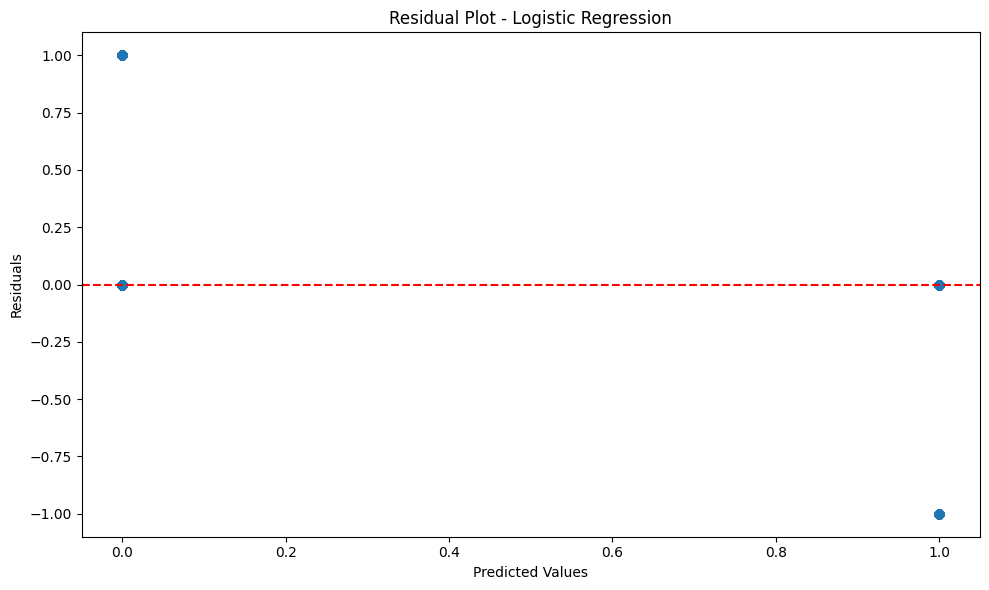

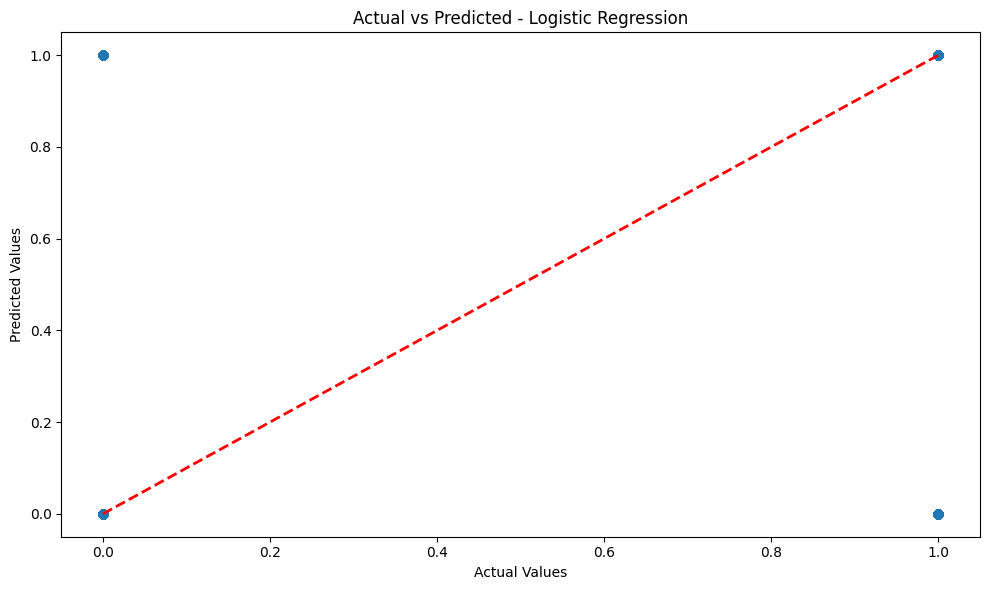

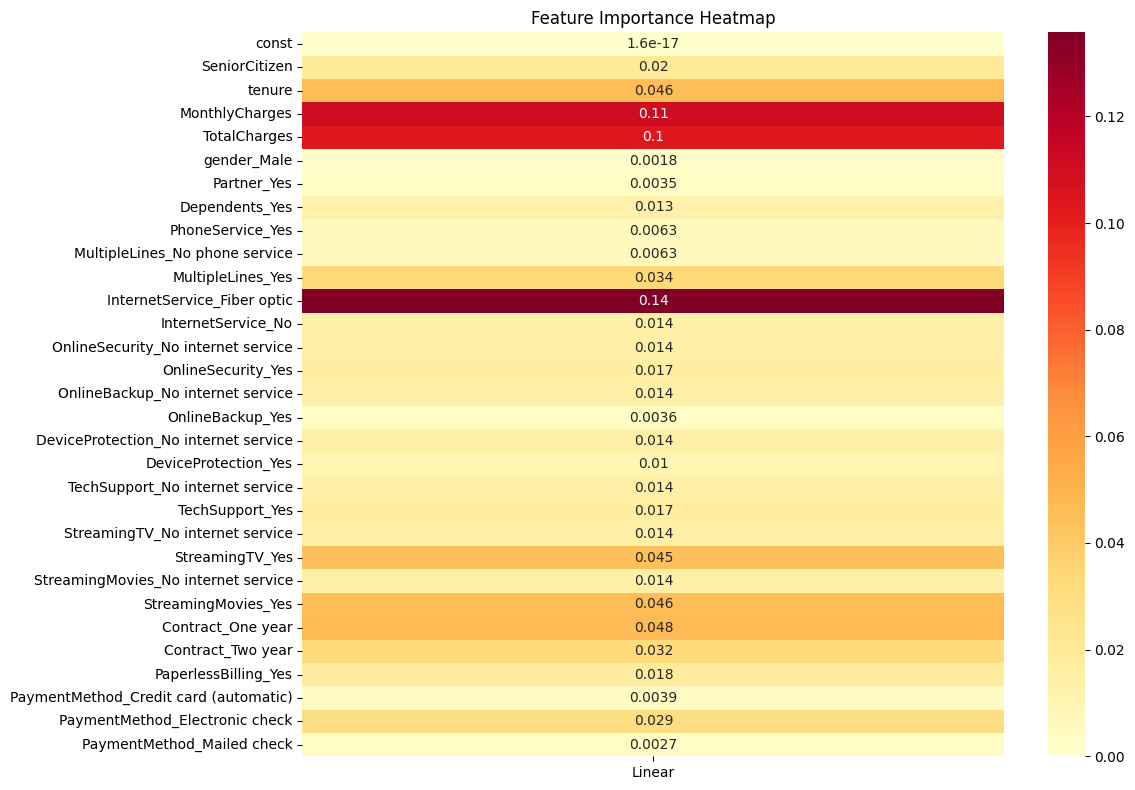

In [20]:
# Creation of Logistic Regression Model, summary and plots

logr_model, logr_pred, logr_pred_proba = evaluate_logr_model(LogisticRegression(max_iter=1000), X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")

plot_residuals(y_test, logr_pred, 'Logistic Regression')

plot_actual_vs_predicted(y_test, logr_pred, 'Logistic Regression')

plot_feature_importance_heatmap(lr_model)

# Used prior functions from: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/interpretable-ml-example-notebooks/regression-interpretability.ipynb

# Analysis of Logistic Regression

The graphs are not particularly useful to look at, and the feature coefficients don't line up with the feature importance heatmap as much as they did with linear regression, but large values are still relatively significant. We can see that the same features as in linear regression were important in the model.

The accuracy is actually slightly worse than in linear regression. Perhaps it is an insignificant difference, and both are capturing easy trends.

In [21]:
# Test for Independence of Observations 

# Residuals from logistic regression
residuals = logr_model.predict(X_train_scaled) - y_train
dw_stat = durbin_watson(residuals)

print(f"Durbin-Watson Statistic: {dw_stat}")


Durbin-Watson Statistic: 2.00464252553389


In [22]:
# Test for logit linearity

# Add Box-Tidwell interaction terms (with small constant to avoid log(0))
epsilon = 1e-10
X_train_scaled['tenure_log'] = X_train_scaled['tenure'] * np.log(X_train_scaled['tenure'] + epsilon)
X_train_scaled['MonthlyCharges_log'] = X_train_scaled['MonthlyCharges'] * np.log(X_train_scaled['MonthlyCharges'] + epsilon)
X_train_scaled['TotalCharges_log'] = X_train_scaled['TotalCharges'] * np.log(X_train_scaled['TotalCharges'] + epsilon)

# Check for NaN values
print(X_train_scaled.isnull().sum())

# Drop or fill NaN values if they exist
X_train_scaled = X_train_scaled.fillna(0)  # Replace NaN with 0 (or use median/mean)

# Fit logistic regression with interaction terms
logr_model_interaction = LogisticRegression(max_iter=1000)
logr_model_interaction.fit(X_train_scaled, y_train)

# Print feature coefficients and their corresponding p-values
coef_interaction = logr_model_interaction.coef_.flatten()
features = X_train_scaled.columns

# Print feature coefficients
print("\nFeature Coefficients with Interaction Terms:")
for feature, coef in zip(features, coef_interaction):
    print(f"{feature}: {coef:.4f}")

# Written by ChatGPT

const                                       0
SeniorCitizen                               0
tenure                                      0
MonthlyCharges                              0
TotalCharges                                0
gender_Male                                 0
Partner_Yes                                 0
Dependents_Yes                              0
PhoneService_Yes                            0
MultipleLines_No phone service              0
MultipleLines_Yes                           0
InternetService_Fiber optic                 0
InternetService_No                          0
OnlineSecurity_No internet service          0
OnlineSecurity_Yes                          0
OnlineBackup_No internet service            0
OnlineBackup_Yes                            0
DeviceProtection_No internet service        0
DeviceProtection_Yes                        0
TechSupport_No internet service             0
TechSupport_Yes                             0
StreamingTV_No internet service   

/Users/ryan/Projects/XAI/XAIenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ryan/Projects/XAI/XAIenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ryan/Projects/XAI/XAIenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Test for logit linearity
Result are inconclusive from this summary, but further statistical tests can use these numbers to determine if the coefficients are statistically significant and thus would violate the logit linearity assumption.


In [23]:
# GAM Model. Note that I could not get pygam or one hot encoded variables to work.

from sklearn.preprocessing import RobustScaler

# Load the data
csv_file_path = "/Users/ryan/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1/WA_Fn-UseC_-Telco-Customer-Churn.csv"
data = pd.read_csv(csv_file_path, index_col='customerID')

# Handle missing or invalid TotalCharges values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data = data.dropna(subset=['TotalCharges'])

# Encode the target variable (Churn) as binary
data['Churn'] = LabelEncoder().fit_transform(data['Churn'])  # Encode target as binary (No=0, Yes=1)

# Select features and target variable (excluding categorical one-hot encoding)
features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']  # Add more numeric features if desired
X = data[features].values
y = data['Churn'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the spline basis
num_features = X_scaled.shape[1]
bsplines = BSplines(X_scaled, df=[8] * num_features, degree=[3] * num_features)

# Fit the GAM model
gam = GLMGam(y, smoother=bsplines, family=Binomial())
gam_result = gam.fit()

# Self-evaluate the model on the same dataset
X_spline = bsplines.transform(X_scaled)
y_pred_prob = gam_result.predict(exog_smooth=X_spline)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Binary classification

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
summary = gam_result.summary()

print(f"Accuracy: {accuracy:.4f}")
print(summary)

# I tried to use pygam from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/interpretable-ml-example-notebooks/generalized-models-interpretability.ipynb
# It ran into a compatibility issue with how it handled data structures, so I used ChatGPT to write code using sklearn's GAM model

Accuracy: 0.7342
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 7032
Model:                         GLMGam   Df Residuals:                  7009.00
Model Family:                Binomial   Df Model:                        22.00
Link Function:                  Logit   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -3042.3
Date:                Thu, 23 Jan 2025   Deviance:                       6084.5
Time:                        02:04:21   Pearson chi2:                 7.09e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2538
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x0_s0         -0.9484      0.629   

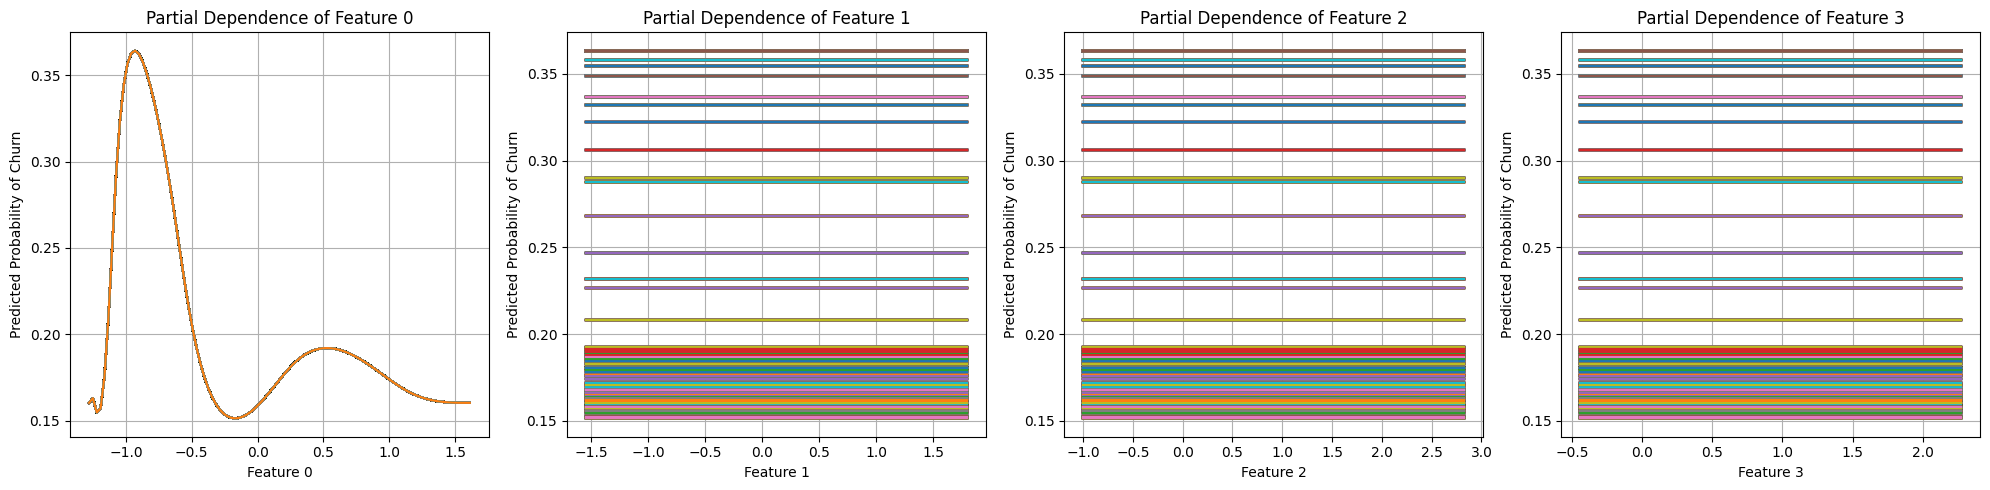

In [24]:
# 1. **Partial Dependence Plots (PDPs)**
# We will manually create a grid of feature values and plot the effect on the predicted probabilities.

def plot_partial_dependence(model, X, feature_index, feature_name, ax=None):
    """
    Generate partial dependence plot for a single feature.
    """
    # Create a grid of values for the given feature
    feature_vals = np.linspace(X[:, feature_index].min(), X[:, feature_index].max(), 100)
    
    # Make a copy of X to manipulate
    X_grid = X.copy()
    
    # Generate predictions for each value in the grid
    y_pred_prob = []
    for val in feature_vals:
        X_grid[:, feature_index] = val  # Set the current feature to the value in the grid
        X_grid_spline = bsplines.transform(X_grid)
        y_pred_prob.append(model.predict(exog_smooth=X_grid_spline))
    
    y_pred_prob = np.array(y_pred_prob)
    
    # Plot the result
    ax.plot(feature_vals, y_pred_prob, label=feature_name)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Predicted Probability of Churn')
    ax.set_title(f"Partial Dependence of {feature_name}")
    ax.grid(True)

# Plot PDPs for each feature
num_features = X_scaled.shape[1]
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(20, 5))
for i in range(num_features):
    plot_partial_dependence(gam_result, X_scaled, i, f"Feature {i}", ax=axes[i])

plt.tight_layout()
plt.show()


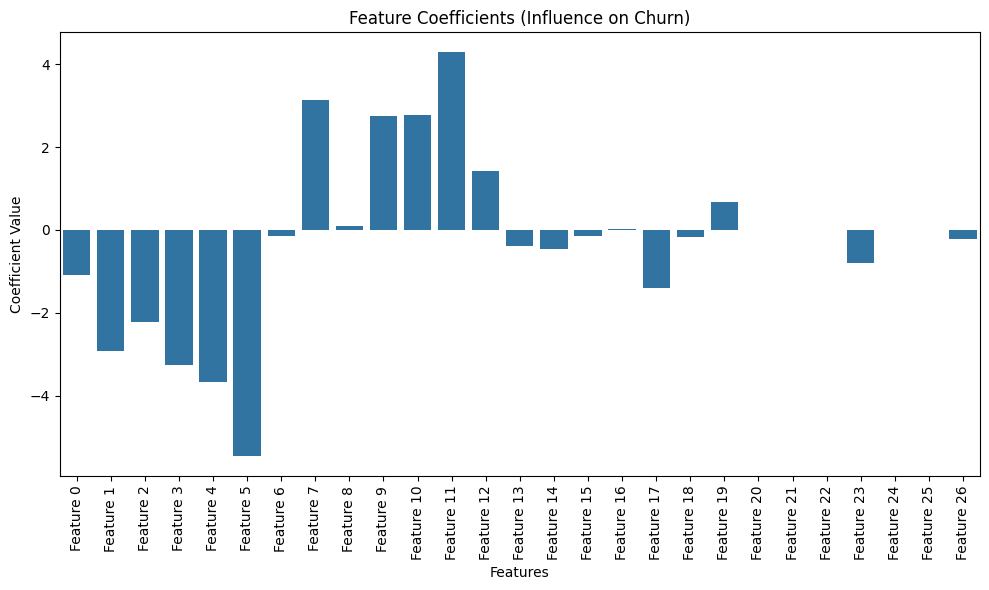

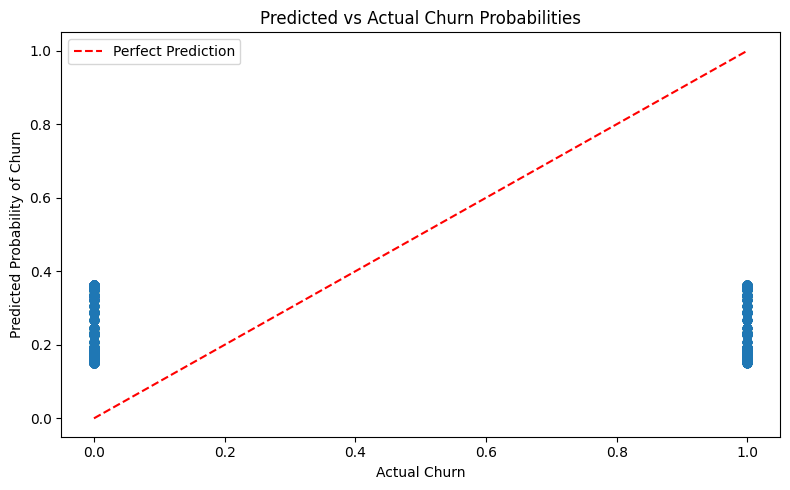

Accuracy: 0.7342


In [25]:
# 2. **Feature Coefficients Plot**
# Get the coefficients from the model (excluding the intercept)
coefficients = gam_result.params[1:]  # Exclude intercept term
features = [f"Feature {i}" for i in range(len(coefficients))]  # Adjust to match the number of coefficients

# Plot feature coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=coefficients)
plt.xticks(rotation=90)
plt.title("Feature Coefficients (Influence on Churn)")
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

# 3. **Predicted vs Actual Plot**
# Predict probabilities for the entire dataset
y_pred_prob_full = gam_result.predict(exog_smooth=bsplines.transform(X_scaled))

# Plot actual vs predicted probabilities
plt.figure(figsize=(8, 5))
plt.scatter(y, y_pred_prob_full, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Churn")
plt.ylabel("Predicted Probability of Churn")
plt.title("Predicted vs Actual Churn Probabilities")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model (Accuracy)
y_pred = (y_pred_prob_full > 0.5).astype(int)  # Binary classification
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# All plots written by ChatGPT

# Analysis of GAM Model

While the accuracy is worse than the regression models, it is interesting to see that more features contribute to the results, and for feature 0 (tenure), the partial dependence is highly non linear and interesting and easy to interpret. 

# Discussion

## Linear Regression
### Strengths
Simple to implement
Easy to interpret
### Weaknesses
Interpretation is oversimplified
Hard to meet assumptions

## Logistic Regression
### Strengths
Easier to adapt to data if assumptions are not met
More appropriate for categorical data
### Weaknesses
Slightly harder to interpret
Harder to validate assumptions

## GAM
### Strengths
Can model highly non linear predictors in an easily interpretable way
### Weaknesses
Can overfit
Raw accuracy is not always better

# Recommendation
Logistic regression. The data is categorical and violates many of the assumptions for linear regression. It is also not so complex that a GAM would be required to model non linearity, and in fact the predictors are largely linearly related to the target.


# References and use of AI

Attempted to share chat but met with error message: Sharing conversations with user uploaded images is not yet supported

ChatGPT 4o, 4o-mini and o1-mini were used.
Most of the code was written by ChatGPT 4o. The process was: write the main body of code (especially for plots), change variables to mine, check for errors (and if so query ChatGPT for solutions if not obvious), ensure result is as expected.
Plots were mostly written by ChatGPT, otherwise taken from the github repository for AIPI590.
Markdown and first and last comments in cells are written by me. ChatGPT was consulted for direction, some interpretation of results and troubleshooting.

Used code snippets from:
https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/interpretable-ml-example-notebooks/regression-interpretability.ipynb
https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/interpretable-ml-example-notebooks/generalized-models-interpretability.ipynb